In [8]:
import csv
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_v2 as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [9]:
#robot initialize
date = 'Setting25_trial0'

#robot 1
#l1 = 0.2
#l2 = 0.2
#m1 = 2
#m2 = 2

#robot 2
l1 = 0.3
l2 = 0.2
m1 = 3
m2 = 2

#robot 3
#l1 = 0.5
#l2 = 0.2
#m1 = 5 
#m2 = 2

#robot 4
#l1 = 0.2 
#l2 = 0.5
#m1 = 2
#m2 = 5

robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
#setting number 5 약간 꼬불꼬불?
# traj 1
#Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
#xpoints = np.array([  0.8,1.8,2.3,1.8,1.3])
#ypoints = np.array([  1.0,1.3,1.6,1.9,2.2])

# traj 2
#Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
#xpoints = np.array([  1.5, 1.25,     1.75,   1.25, 1.75, 1.25])
#ypoints = np.array([  1.3,   1.45,  1.6, 1.75, 1.9, 2.2])

# traj 3
#Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
#xpoints = np.array([  1.0, 1.5, 2.0, 2.2, 2.5])
#ypoints = np.array([  1.0, 1.5, 2.0, 2.2, 2.5])

# traj 4
#Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
#xpoints = np.array([  0.7, 1.5, 1.0, 2.2, 2.5])
#ypoints = np.array([  0.7, 1.0, 1.5, 1.6, 2.5])

# traj 5
Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
xpoints = np.array([  2.5, 1.5, 1.0, 1.5, 0.7])
ypoints = np.array([  0.5, 0.9, 1.5, 1.6, 2.5])
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints,Vpoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 500
V_size = 300
V_hidden_sizes = [V_size, V_size,V_size]
fhat_hidden_sizes = [fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size]
tol = 0.01
alpha = 0.1
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 0#100000
alpha_kinematic = 0.01
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

In [10]:
f = open(date+'_total_data.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['xpoints'])
wr.writerow(xpoints)
wr.writerow(['ypoints'])
wr.writerow(ypoints)
wr.writerow(['T = ',T])
wr.writerow(['delta = ',delta])
wr.writerow(['num_timesteps = ',num_timesteps])
wr.writerow(['alpha = ',alpha])
wr.writerow(['tol =', tol ])
f.close()

# Ploting trajectory

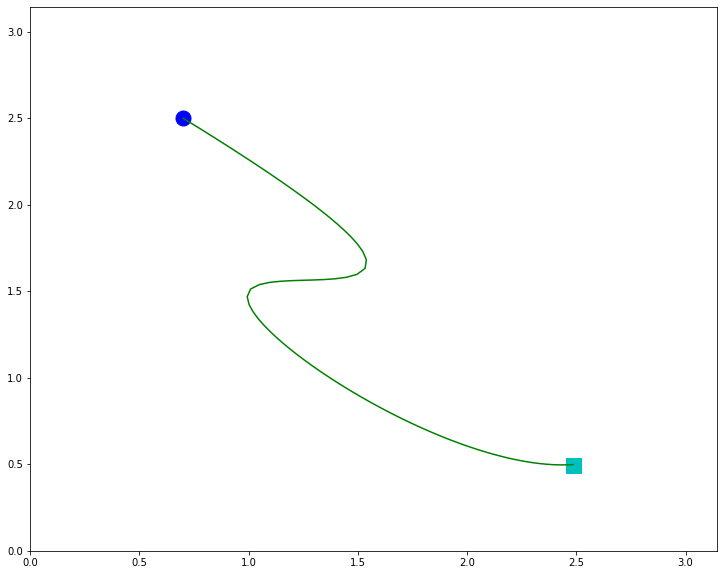

In [11]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

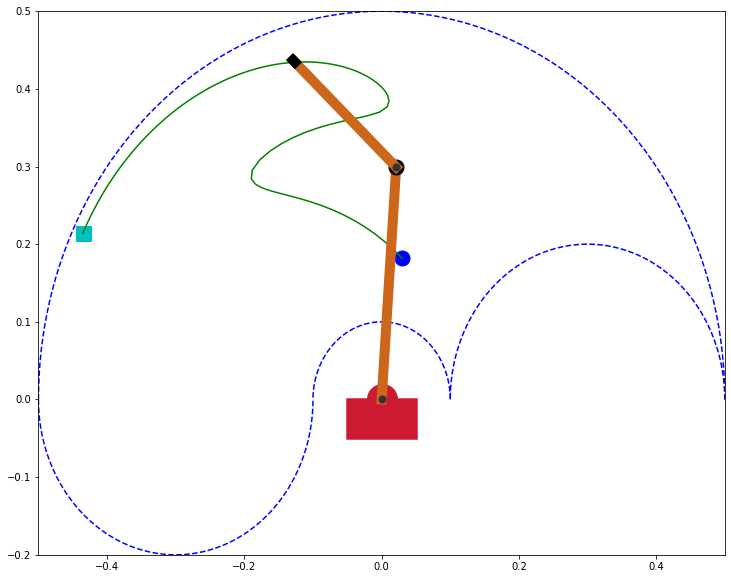

In [12]:
theta1 = xpoints[1]
theta2 = ypoints[1]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

 epoch = 10000, loss = 0.0006507808, loss_b = 1.9823716, loss_t = 0.0006507808                    .. .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

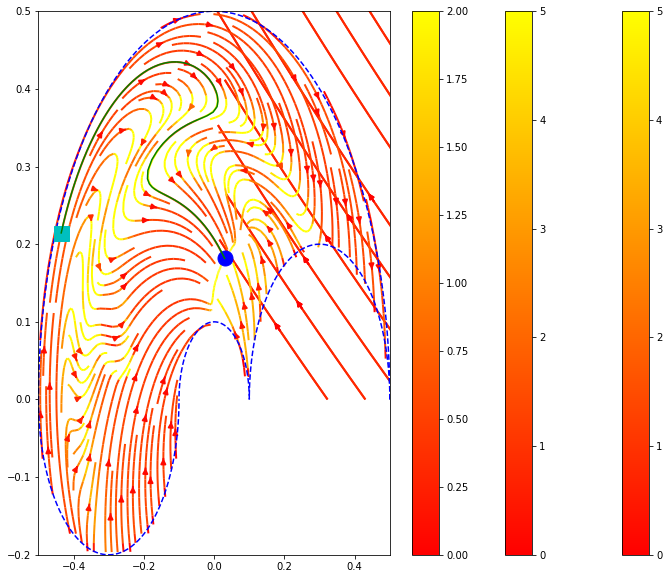

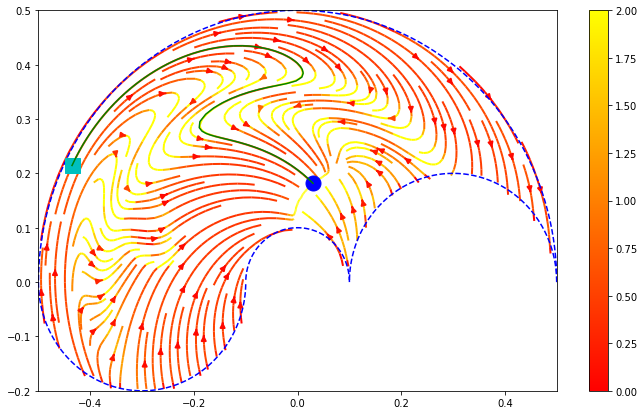

In [14]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)
loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1)
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['No Regularization'])
wr.writerow(['loss_traj_1', 'loss_boundary_1', 'loss_Euc_1', 'loss_kinematic_1', 'loss_kinetic_1'])
wr.writerow([loss_traj_1.data.to(device_c).numpy(), loss_boundary_1.data.to(device_c).numpy(), loss_Euc_1.data.to(device_c).numpy(), loss_kinematic_1.data.to(device_c).numpy(), loss_kinetic_1.data.to(device_c).numpy()])
f.close()
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f('fplot_noreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)

 epoch = 10000, loss = 0.00014001002, loss_b = 2.1579068, loss_t = 0.00014001002                    .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

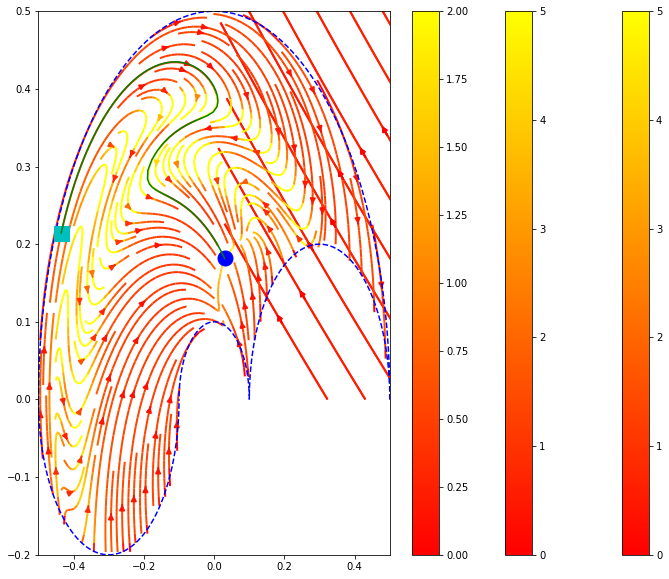

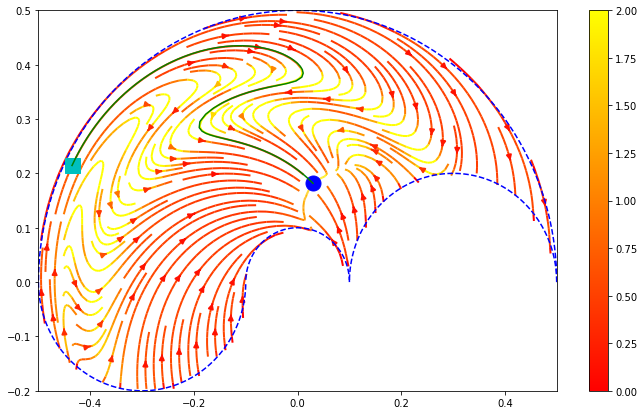

In [15]:
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)
loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2)
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Weight Regularization'])
wr.writerow(['loss_traj_2', 'loss_boundary_2', 'loss_Euc_2', 'loss_kinematic_2', 'loss_kinetic_2'])
wr.writerow([loss_traj_2.data.to(device_c).numpy(), loss_boundary_2.data.to(device_c).numpy(), loss_Euc_2.data.to(device_c).numpy(), loss_kinematic_2.data.to(device_c).numpy(), loss_kinetic_2.data.to(device_c).numpy()])
f.close()
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_wreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f('fplot_wreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)

 i = 10000, loss = 66.49629, total_loss = 102.37914, loss_t = 0.009000309, loss_reg = 6.5738134, loss_reg_total =  42.512405           ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

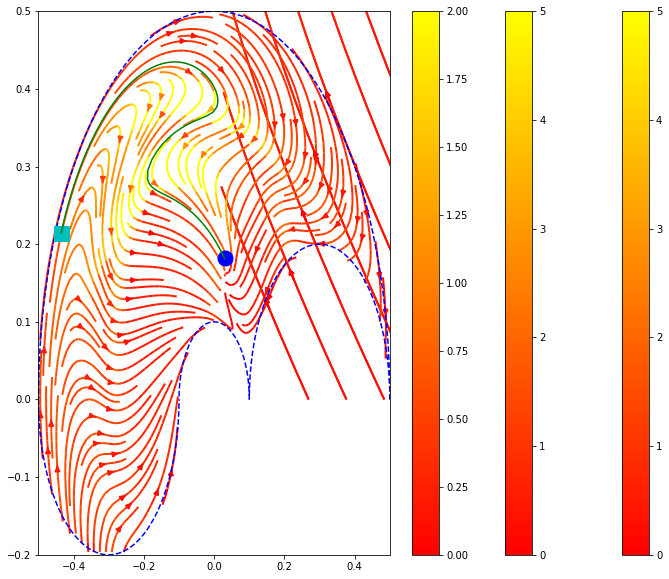

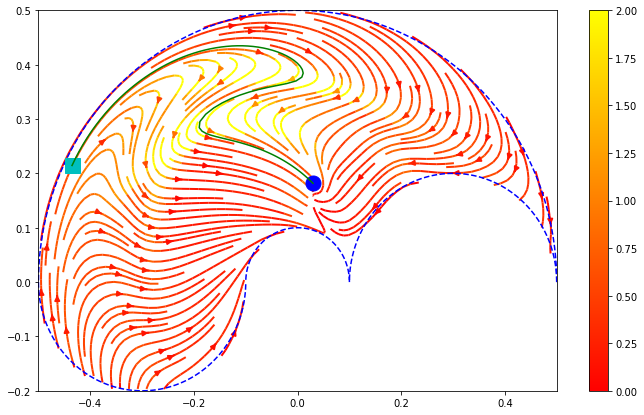

In [16]:
#mode 0: exp barrier, 1: relu squared
mode = 2
penalty = 50
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 1e-5,epoch=10000, batch_size = 400,penalty_mode = mode)
loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3)
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Euclidean Regularization'])
wr.writerow(['loss_traj_3', 'loss_boundary_3', 'loss_Euc_3', 'loss_kinematic_3', 'loss_kinetic_3'])
wr.writerow([loss_traj_3.data.to(device_c).numpy(), loss_boundary_3.data.to(device_c).numpy(), loss_Euc_3.data.to(device_c).numpy(), loss_kinematic_3.data.to(device_c).numpy(), loss_kinetic_3.data.to(device_c).numpy()])
f.close()
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_Eucreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f('fplot_Eucreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)

 i = 10000, loss = 11.535455, total_loss = 11.652793, loss_b = 1.0262774, loss_t = 6.656418e-05, loss_reg = 0.019199373, loss_reg_total =  0.13685074           ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

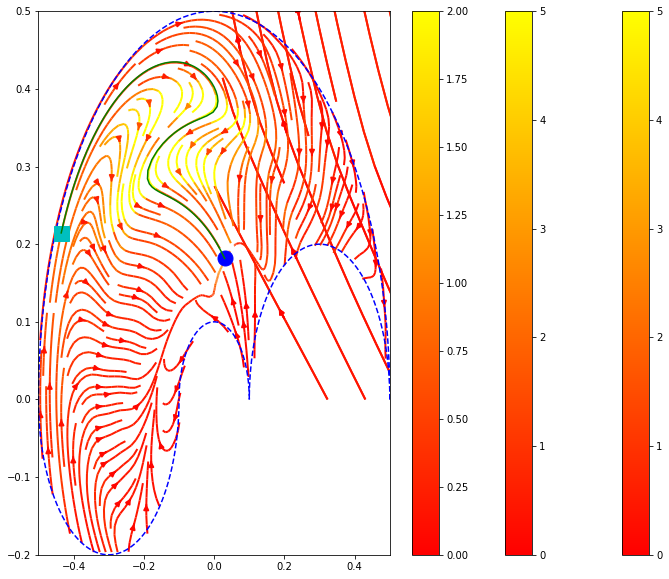

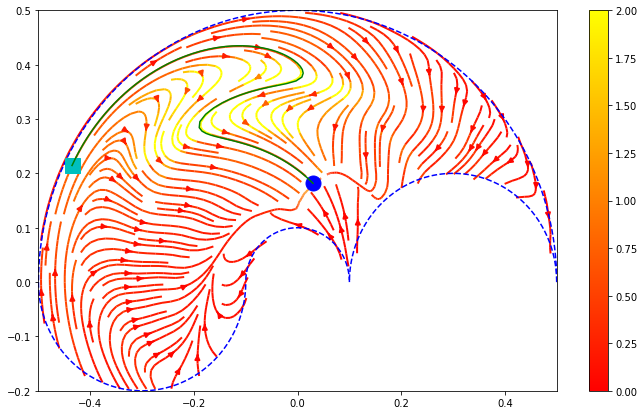

In [17]:
penalty = 10
penalty_boundary = 0
mode = 2
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable,alpha_kinematic, learning_rate = 3e-6,epoch=10000, batch_size = 64,penalty_mode = mode)
loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4)
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinematic Regularizatio'])
wr.writerow(['loss_traj_4', 'loss_boundary_4', 'loss_Euc_4', 'loss_kinematic_4', 'loss_kinetic_4'])
wr.writerow([loss_traj_4.data.to(device_c).numpy(), loss_boundary_4.data.to(device_c).numpy(), loss_Euc_4.data.to(device_c).numpy(), loss_kinematic_4.data.to(device_c).numpy(), loss_kinetic_4.data.to(device_c).numpy()])
f.close()
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kinematicreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f('fplot_kinematicreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)

 i = 10000, loss = 11.589839, total_loss = 11.710089, loss_b = 1.1781069, loss_t = 7.612956e-05, loss_reg = 0.073105544, loss_reg_total =  0.19344255           ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

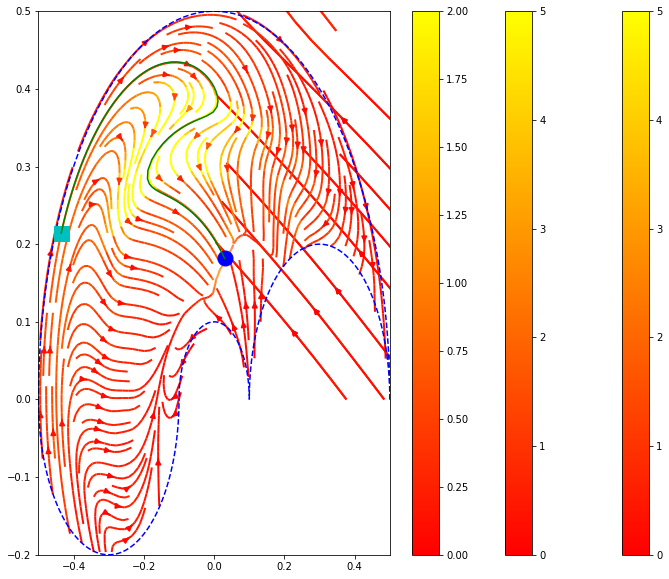

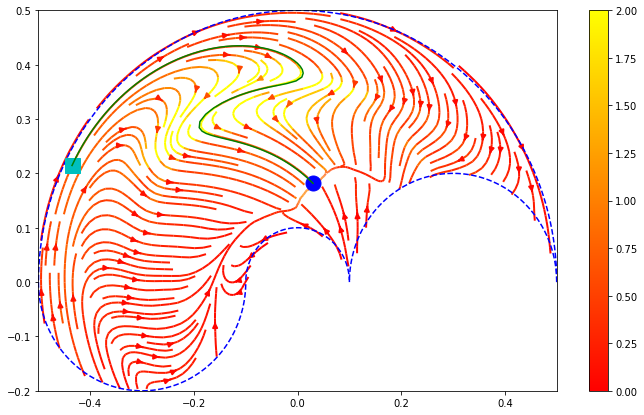

In [18]:
penalty = 10
penalty_boundary = 0
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-6,epoch=10000, batch_size = 40,penalty_mode = 2)
loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5)
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinetic Regularization'])
wr.writerow(['loss_traj_5', 'loss_boundary_5', 'loss_Euc_5', 'loss_kinematic_5', 'loss_kinetic_5'])
wr.writerow([loss_traj_5.data.to(device_c).numpy(), loss_boundary_5.data.to(device_c).numpy(), loss_Euc_5.data.to(device_c).numpy(), loss_kinematic_5.data.to(device_c).numpy(), loss_kinetic_5.data.to(device_c).numpy()])
f.close()
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kineticreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f('fplot_kineticreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)

# No Regularization

In [7]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [8]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 10000, loss = 0.00019268306, loss_b = 1.7877363, loss_t = 0.00019268306                    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [9]:
loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0017, device='cuda:0') tensor(16.0893, device='cuda:0', grad_fn=<MulBackward0>) tensor(3016.0620) tensor(4.5820, device='cuda:0') tensor(8.2764, device='cuda:0')


In [10]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['No Regularization'])
wr.writerow(['loss_traj_1', 'loss_boundary_1', 'loss_Euc_1', 'loss_kinematic_1', 'loss_kinetic_1'])
wr.writerow([loss_traj_1.data.to(device_c).numpy(), loss_boundary_1.data.to(device_c).numpy(), loss_Euc_1.data.to(device_c).numpy(), loss_kinematic_1.data.to(device_c).numpy(), loss_kinetic_1.data.to(device_c).numpy()])
f.close()

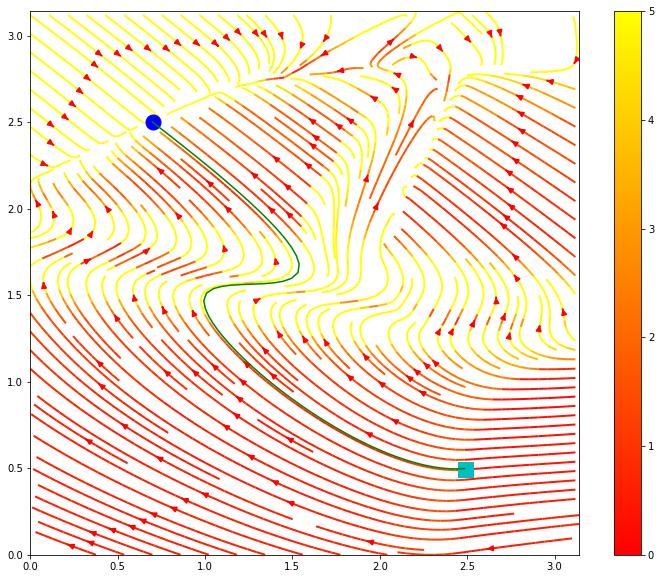

In [11]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

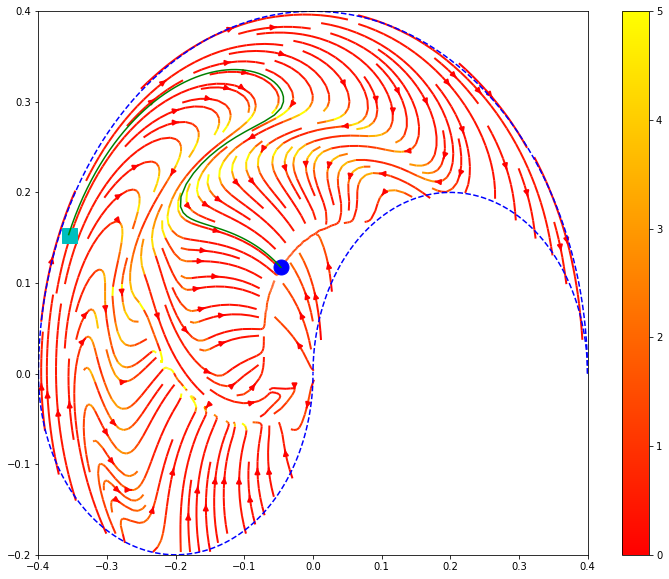

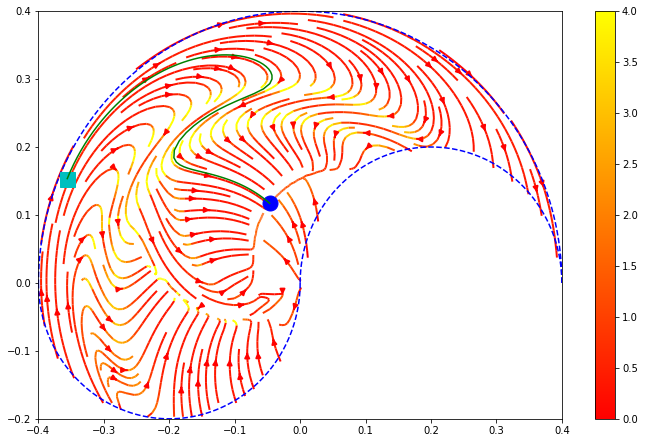

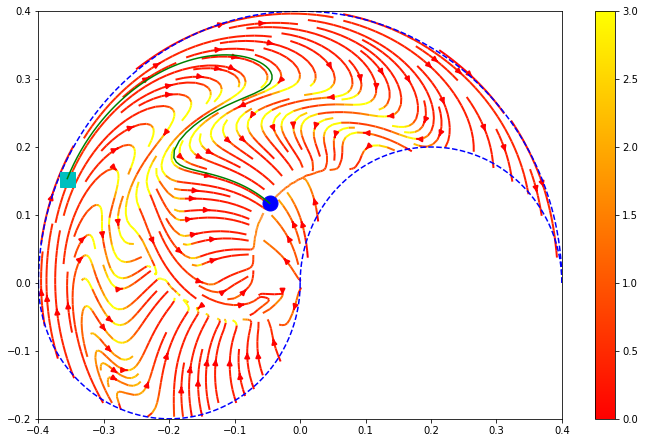

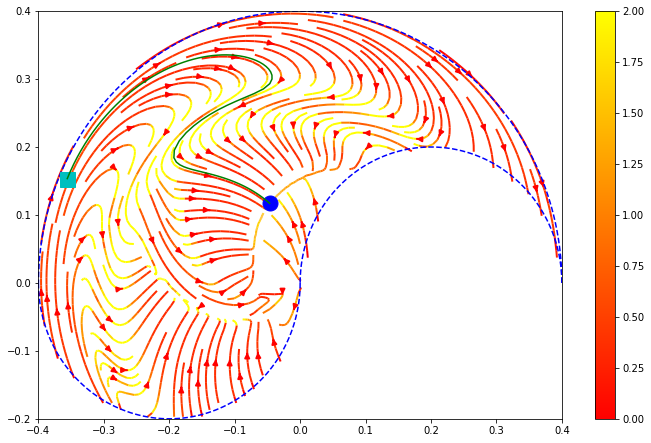

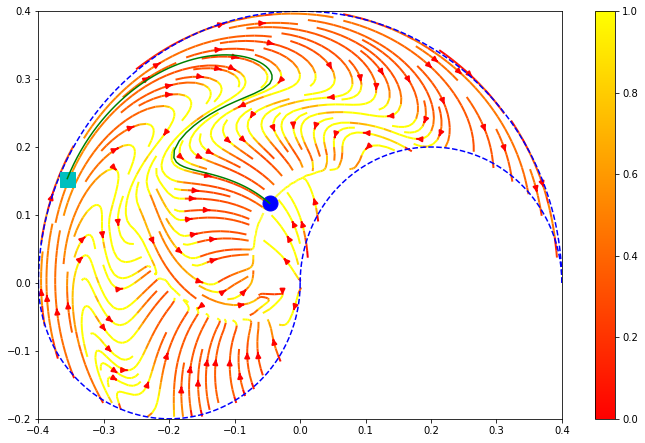

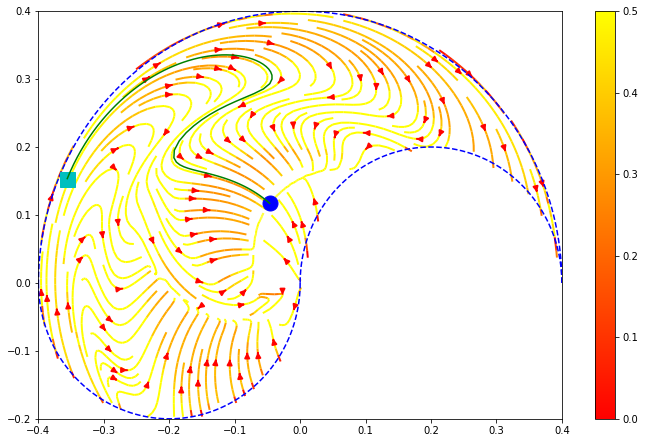

In [12]:
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

## weight norm decay

In [53]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [18]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 2777, loss = 0.00047899218, loss_b = 1.4950919, loss_t = 0.00047899218                    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

KeyboardInterrupt: 

In [13]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 10000, loss = 0.003918794, loss_b = 1.571767, loss_t = 0.003918794                    . . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [14]:
loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0567, device='cuda:0') tensor(15.5542, device='cuda:0', grad_fn=<MulBackward0>) tensor(1043.4141) tensor(3.6204, device='cuda:0') tensor(6.7062, device='cuda:0')


In [15]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Weight Regularization'])
wr.writerow(['loss_traj_2', 'loss_boundary_2', 'loss_Euc_2', 'loss_kinematic_2', 'loss_kinetic_2'])
wr.writerow([loss_traj_2.data.to(device_c).numpy(), loss_boundary_2.data.to(device_c).numpy(), loss_Euc_2.data.to(device_c).numpy(), loss_kinematic_2.data.to(device_c).numpy(), loss_kinetic_2.data.to(device_c).numpy()])
f.close()

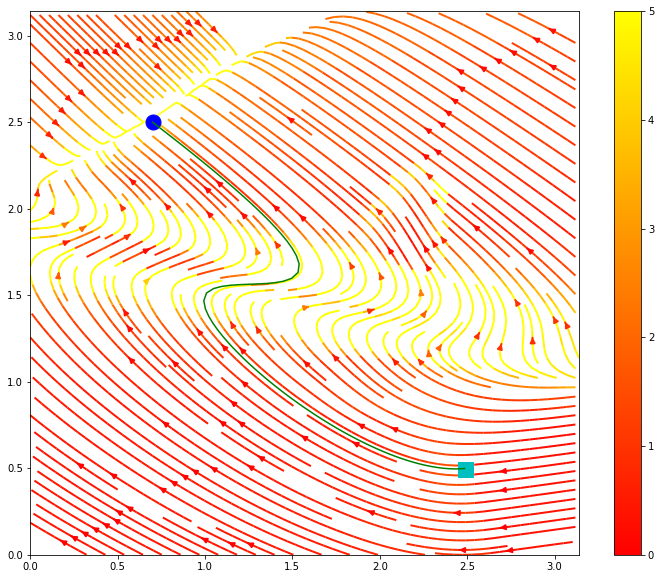

In [16]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_wreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

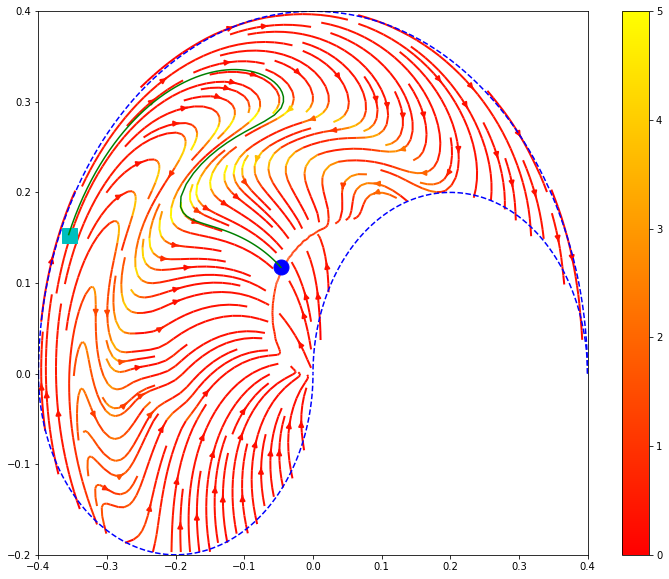

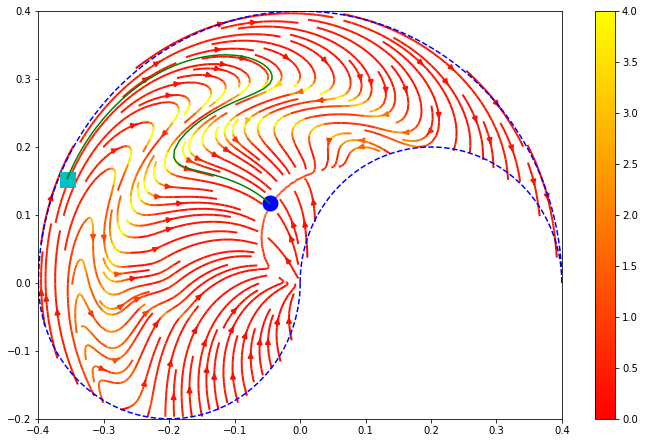

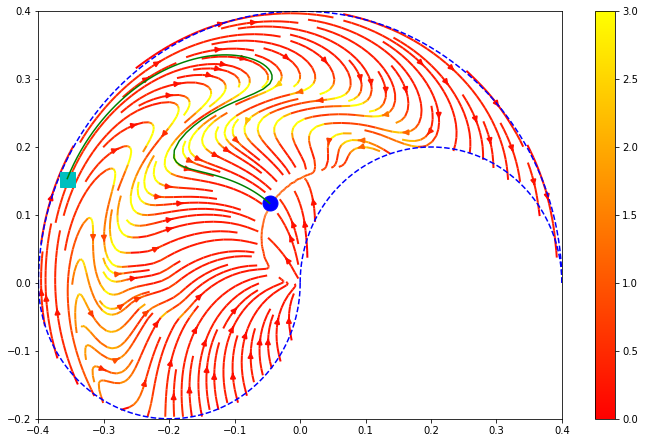

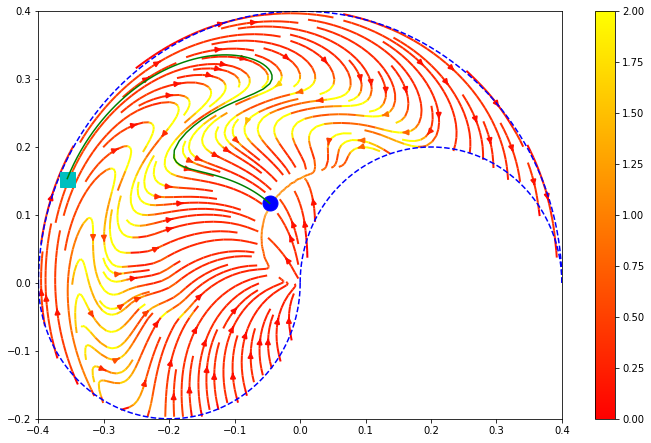

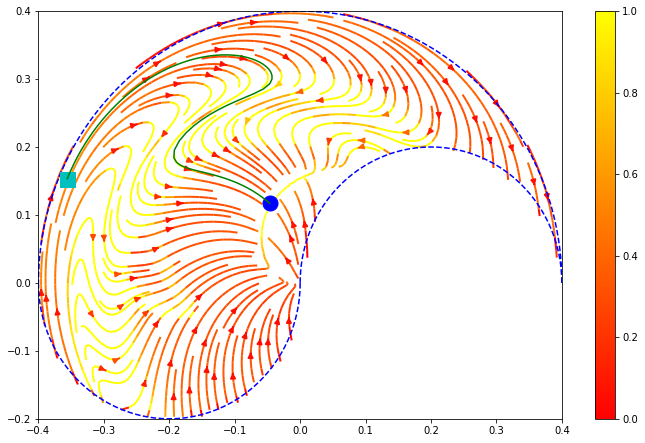

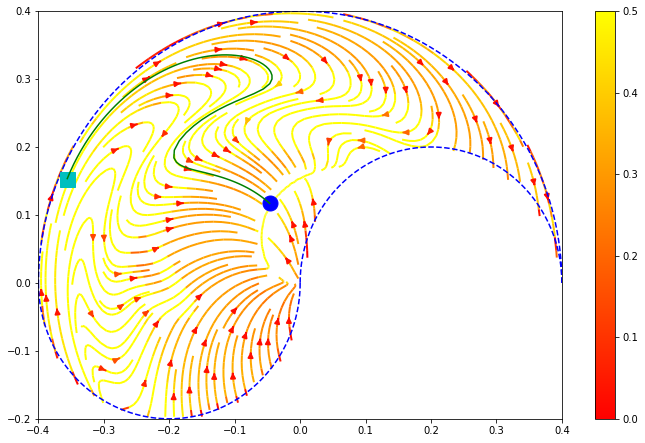

In [17]:
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Euclidean Regularization

In [10]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [11]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 9233, loss = 0.0005495005, loss_b = 1.6633934, loss_t = 0.0005495005                    . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [9]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 5323, loss = 0.0002064217, loss_b = 1.2976735, loss_t = 0.0002064217                    . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [ ]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
penalty = 50
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 1e-5,epoch=100000, batch_size = 400,penalty_mode = mode)

 i = 90142, loss = 69.2363, total_loss = 101.40691, loss_t = 0.007030194, loss_reg = 9.849279, loss_reg_total =  41.825336           . .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3)

In [ ]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Euclidean Regularization'])
wr.writerow(['loss_traj_3', 'loss_boundary_3', 'loss_Euc_3', 'loss_kinematic_3', 'loss_kinetic_3'])
wr.writerow([loss_traj_3.data.to(device_c).numpy(), loss_boundary_3.data.to(device_c).numpy(), loss_Euc_3.data.to(device_c).numpy(), loss_kinematic_3.data.to(device_c).numpy(), loss_kinetic_3.data.to(device_c).numpy()])
f.close()

In [ ]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_Eucreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

In [ ]:
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinematic Regularization

In [55]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [56]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 953, loss = 0.0009891486, loss_b = 1.4313619, loss_t = 0.0009891486                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [20]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 801, loss = 0.00031313286, loss_b = 0.0, loss_t = 0.00031313286                    .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [23]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared

penalty = 10
penalty_boundary = 0
mode = 2
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable,alpha_kinematic, learning_rate = 3e-6,epoch=30000, batch_size = 64,penalty_mode = mode)

 i = 30000, loss = nan, total_loss = nan, loss_b = 2.6692746, loss_t = 478172.66, loss_reg = 29.46858, loss_reg_total =  183.81245           .  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [24]:
loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(4282423., device='cuda:0') tensor(27.7613, device='cuda:0', grad_fn=<MulBackward0>) tensor(65645120.) tensor(957.3865, device='cuda:0') tensor(2601.8772, device='cuda:0')


In [25]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinematic Regularizatio'])
wr.writerow(['loss_traj_4', 'loss_boundary_4', 'loss_Euc_4', 'loss_kinematic_4', 'loss_kinetic_4'])
wr.writerow([loss_traj_4.data.to(device_c).numpy(), loss_boundary_4.data.to(device_c).numpy(), loss_Euc_4.data.to(device_c).numpy(), loss_kinematic_4.data.to(device_c).numpy(), loss_kinetic_4.data.to(device_c).numpy()])
f.close()

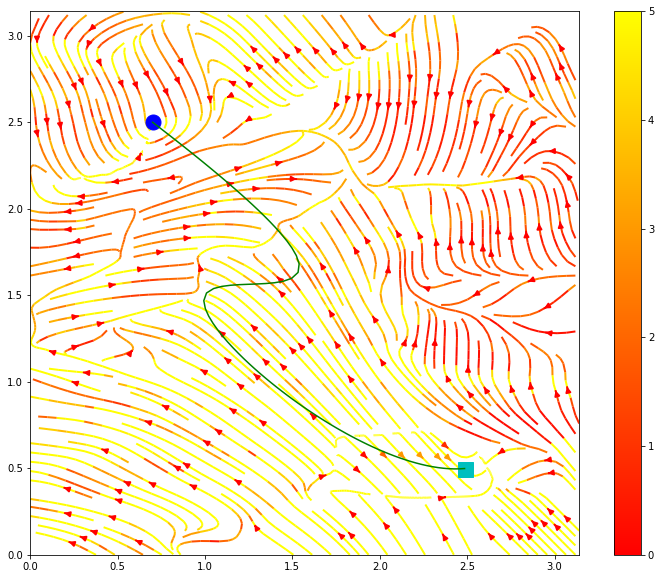

In [26]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kinematicreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

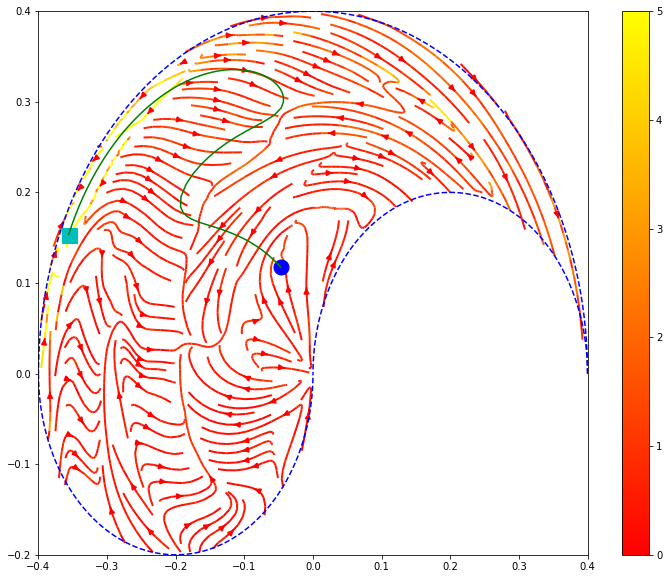

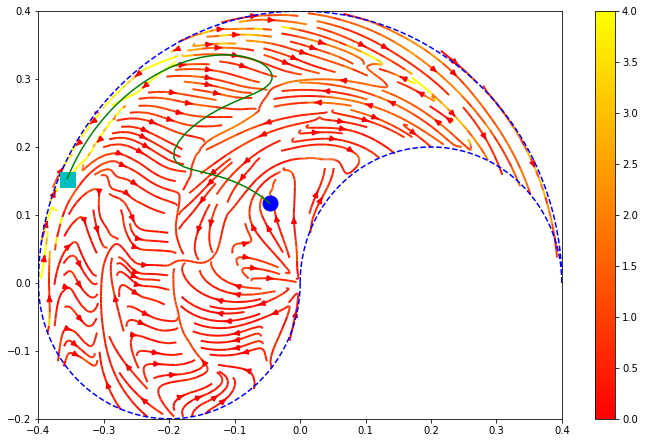

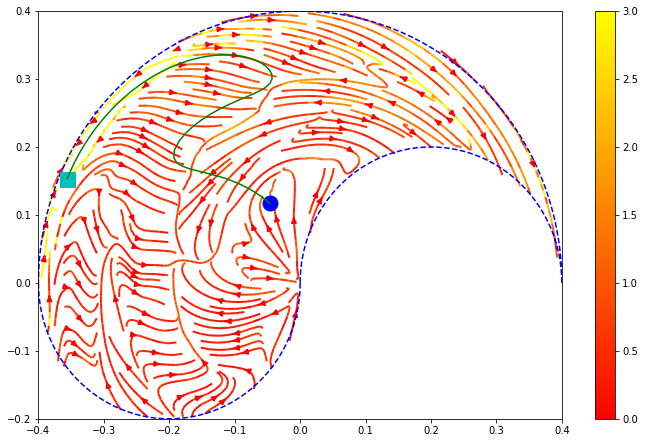

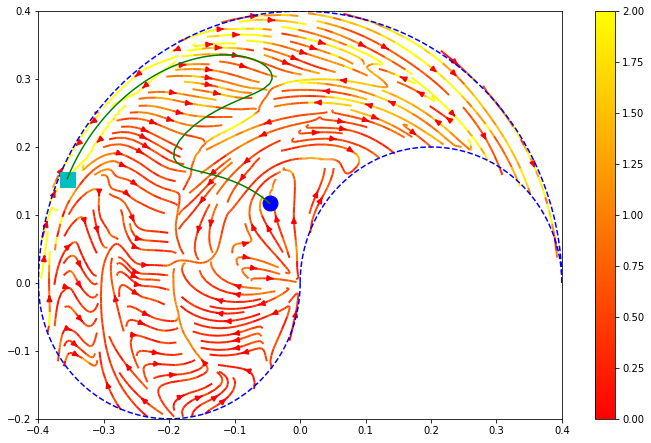

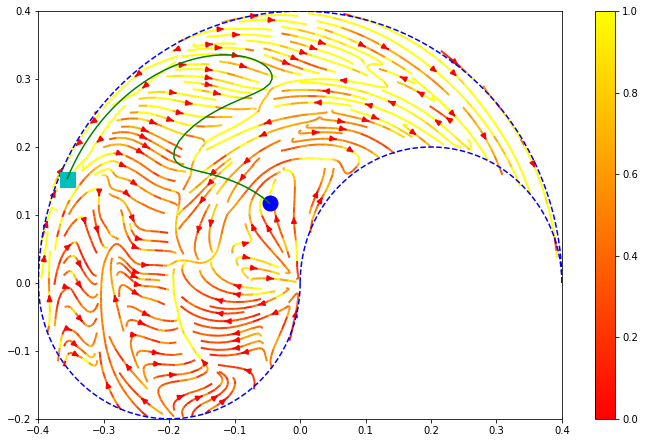

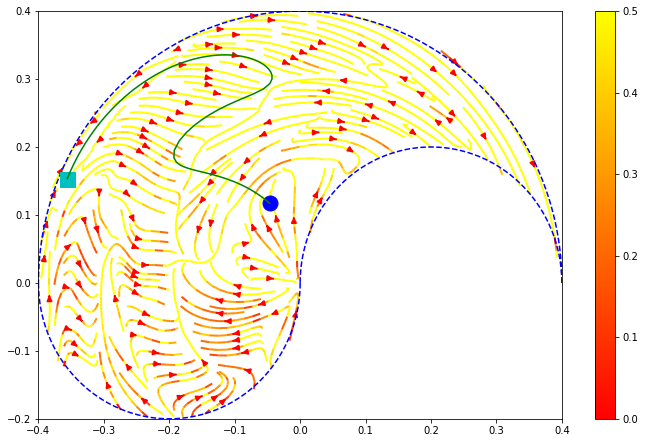

In [27]:
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinetic Regularization

In [45]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [46]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 4e-4 ,epoch=10000)

 epoch = 975, loss = 0.0012405277, loss_b = 2.3193538, loss_t = 0.0012405277                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [27]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1145, loss = 0.0002940032, loss_b = 0.0, loss_t = 0.0002940032                    . .     .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [28]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
penalty = 10
penalty_boundary = 0
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-6,epoch=150000, batch_size = 40,penalty_mode = 2)

 i = 8738, loss = nan, total_loss = nan, loss_b = 3.305791, loss_t = 1869538.8, loss_reg = 0.016519455, loss_reg_total =  2494.8545           ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

KeyboardInterrupt: 

In [ ]:
loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5)

In [ ]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinetic Regularization'])
wr.writerow(['loss_traj_5', 'loss_boundary_5', 'loss_Euc_5', 'loss_kinematic_5', 'loss_kinetic_5'])
wr.writerow([loss_traj_5.data.to(device_c).numpy(), loss_boundary_5.data.to(device_c).numpy(), loss_Euc_5.data.to(device_c).numpy(), loss_kinematic_5.data.to(device_c).numpy(), loss_kinetic_5.data.to(device_c).numpy()])
f.close()

In [ ]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kineticreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

In [ ]:
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)